In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
from typing import DefaultDict, List, Hashable, Dict, Any

from src.utils.utils import get_generator, get_project_root, make_path_if_not_exists

from src.pipeline.config import DataLoaderConfig, TaskLoaderConfig
from src.pipeline.taskloader import TaskLoader
from src.pipeline.dataloader import DataLoader

from src.orchestrator.trainer import Trainer
from src.utils.result_fetcher import ResultFetcher

from src.settings.tier import Tier
from src.settings.strategy import Strategy

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import itertools

In [3]:
DataLoader.DATA_FOLDER = f'{get_project_root()}/data/training/'
tier = Tier.TIER0

dl_config = DataLoaderConfig(
    additional_filters=['is_precursor'],
    additional_transforms=["log_fold_change_protein"]
)

dl = DataLoader()
dl.prepare_dataloader(dl_config)

tl = TaskLoader()
tl.prepare_taskloader(TaskLoaderConfig())
strategy = Strategy.ALL
gen = get_generator(dl, tl, strategy, tier)
tf = next(gen)

ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7ffb943ed850>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7ffb943ed490>>])


In [4]:
MODE = 'talk'
FIGSIZE = (0, 0)
DPI = 0

# Paper dimensions

# Presentation dimensions
LABEL_SIZE_TALK = 16
DPI_TALK = 96
FIGSIZE_TALK = (13.33, 7.5)
FONTSIZE_TALK = 18

def save_fig(path: str, name: str):
    make_path_if_not_exists(path)
    plt.savefig(f"{path}/{name}.png", bbox_inches='tight')
    plt.savefig(f"{path}/{name}.svg", bbox_inches='tight')

# Single mutation enzyme

In [5]:
domain = [np.exp(-2), np.exp(2)]

df_single = pd.read_csv('./data/validation/single_mutation.csv')
df_single = df_single.rename({'level_0': 'sample_id', 'level_1': 'metabolite_id', '0': 'metabolite_concentration'}, axis=1)

df_single = df_single.merge(
    pd.Series(np.arange(domain[0], domain[1], 0.1), name='fc', index=range(73)),
    left_on='sample_id',
    right_index=True
)

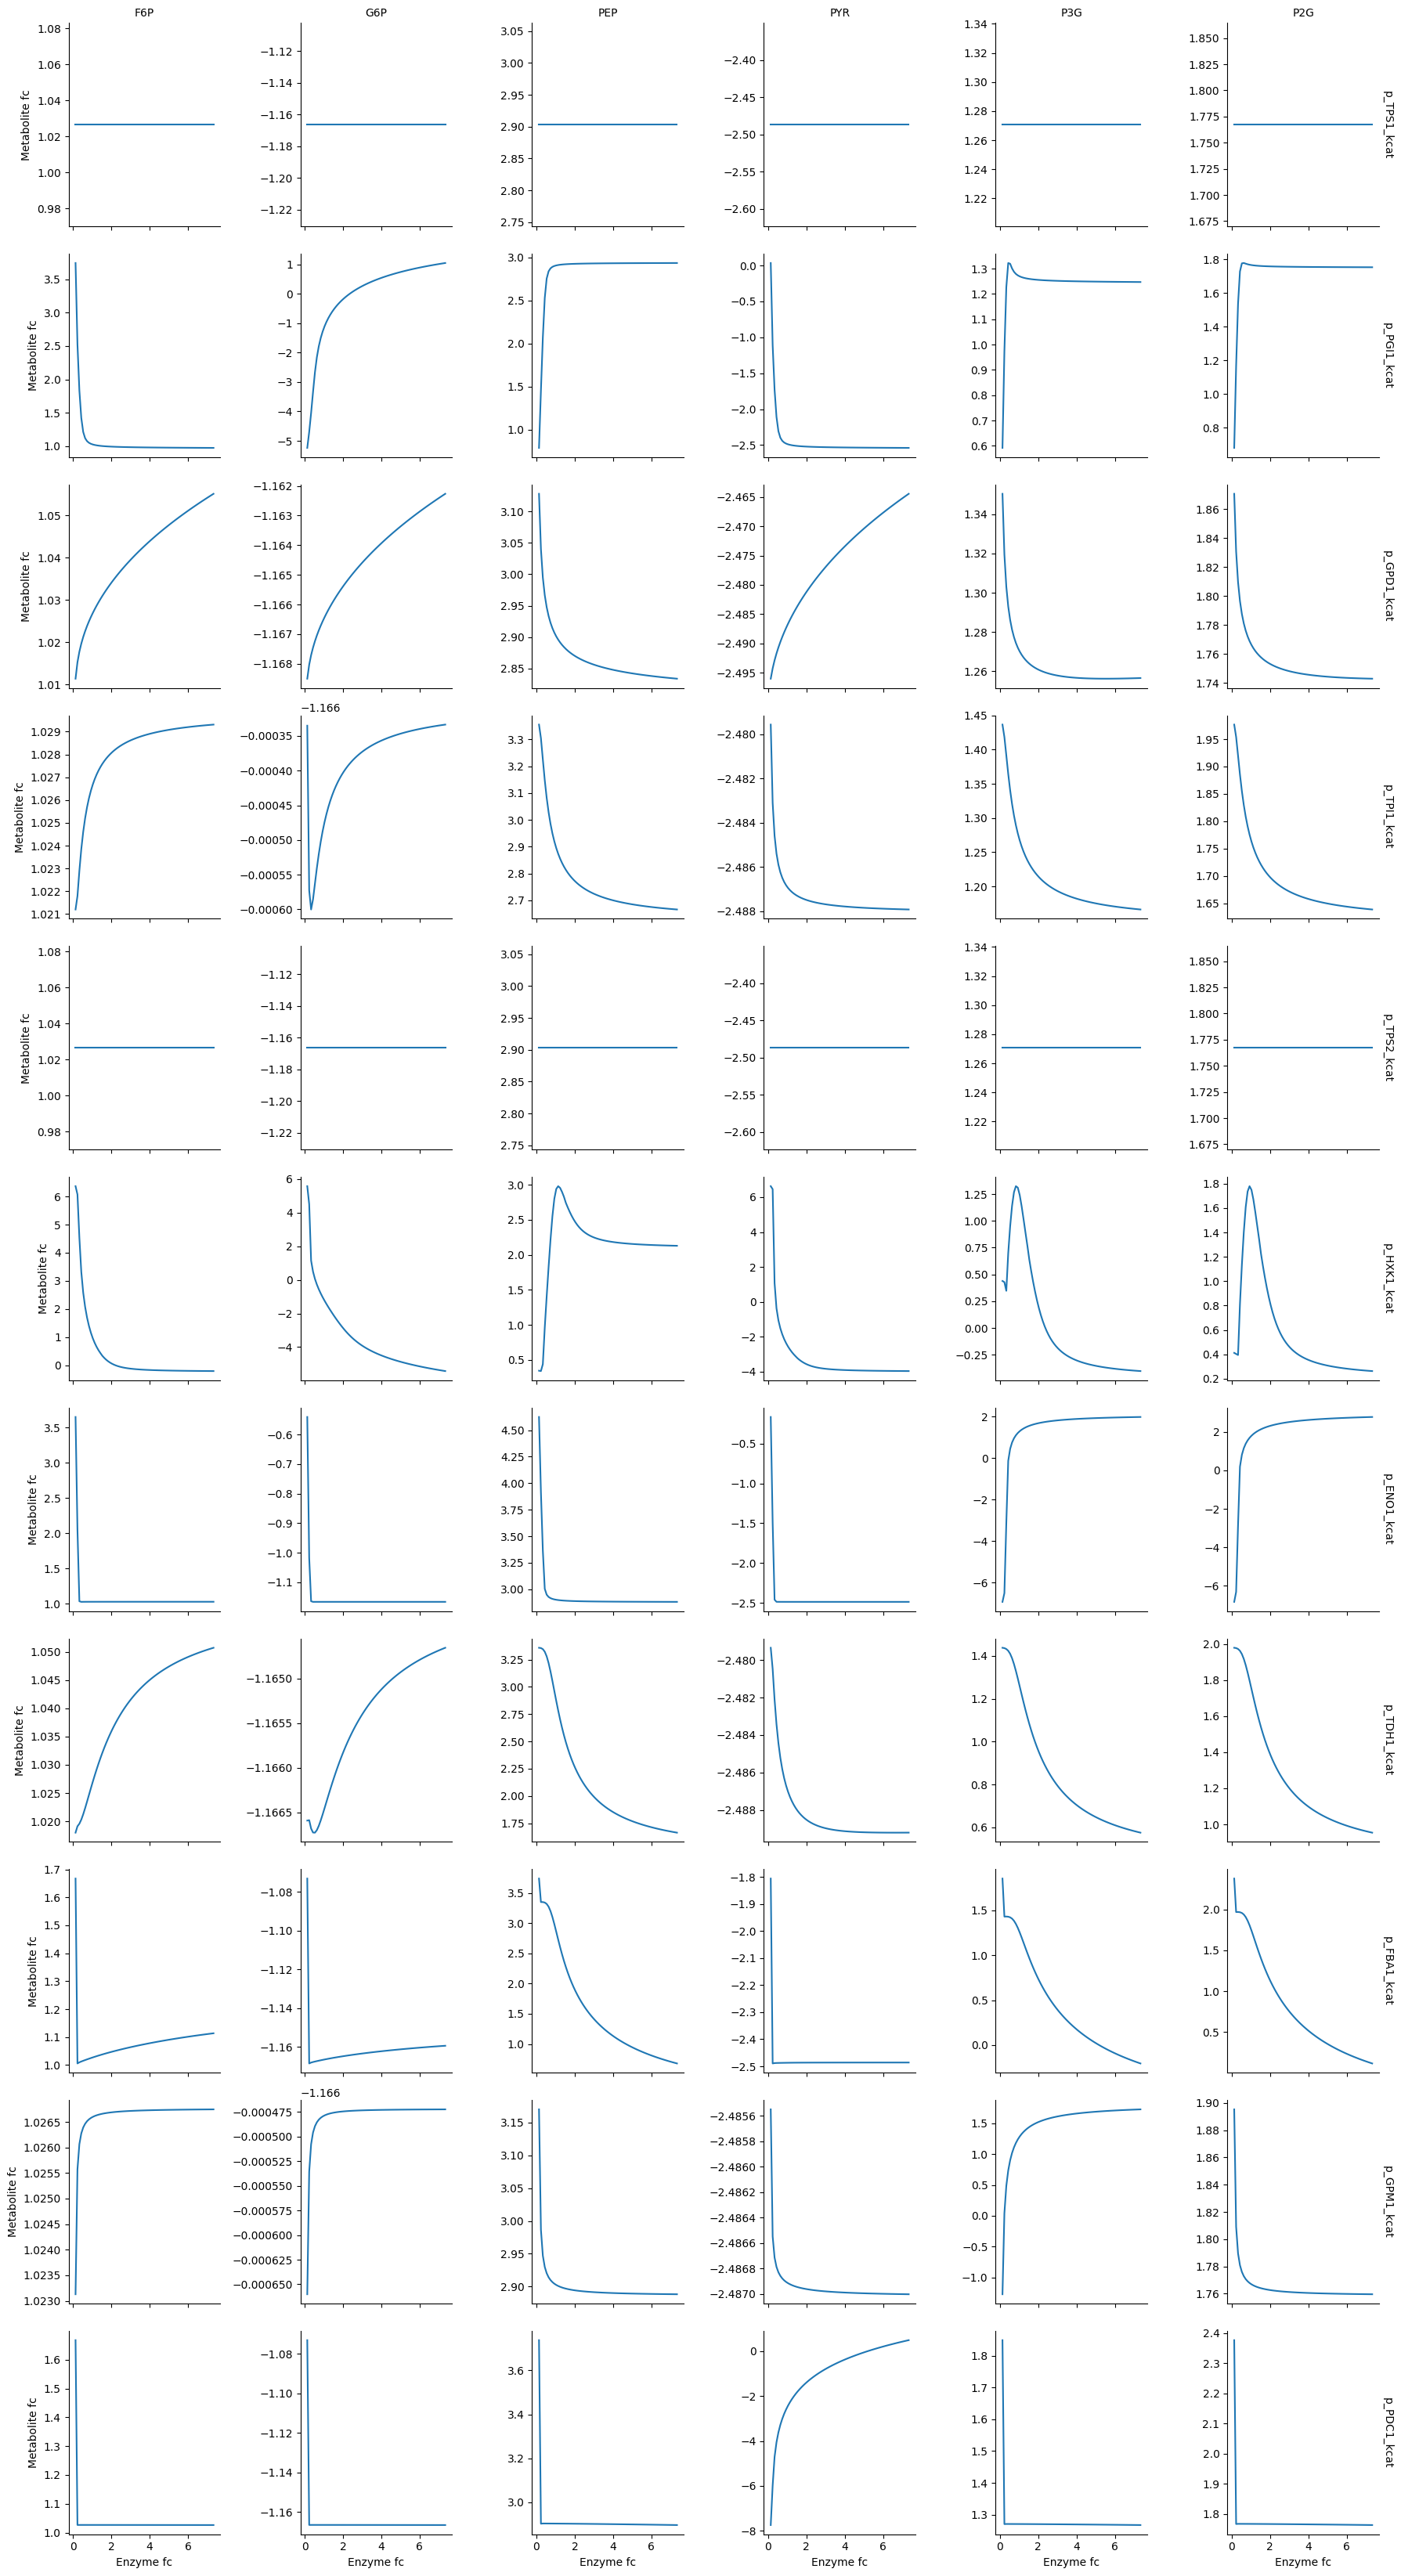

In [6]:
g = sns.FacetGrid(
    data=df_single,
    col='metabolite_id',
    row='catalyzation_id',
    # col_wrap=12,
    sharey=False,
    margin_titles=True,
)
g.map(sns.lineplot, "fc", "metabolite_concentration")
g.set_axis_labels("Enzyme fc", "Metabolite fc")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

In [7]:
df_single.sort_values(by='metabolite_concentration')

,Unnamed: 0,sample_id,metabolite_id,metabolite_concentration,catalyzation_id,fc
4383,3,0,PYR,-7.740215,p_PDC1_kcat,0.135335
2632,4,0,P3G,-6.918221,p_ENO1_kcat,0.135335
2633,5,0,P2G,-6.835039,p_ENO1_kcat,0.135335
2638,10,1,P3G,-6.498321,p_ENO1_kcat,0.235335
2639,11,1,P2G,-6.318260,p_ENO1_kcat,0.235335
...,...,...,...,...,...,...
2191,1,0,G6P,5.563892,p_HXK1_kcat,0.135335
2196,6,1,F6P,6.073039,p_HXK1_kcat,0.235335
2190,0,0,F6P,6.366818,p_HXK1_kcat,0.135335
2199,9,1,PYR,6.456195,p_HXK1_kcat,0.235335


In [8]:
SAMPLE_IDS = np.tile(df_single['sample_id'].unique().tolist(), 11)

def parse_kinetic_model_id_to_orf(kinetic_model_ids: List[str]):
    mapping = pd.read_csv("./data/misc/orf_to_catalyzation_id_mapping.csv")
    return [mapping[mapping["catalyzation_ids"] == kinetic_model_id]["orf"].values[0] for kinetic_model_id in kinetic_model_ids]

def embed_mutation(enzyme_concentration, target_enzyme_ids):
    embedded_fc = np.zeros(
        shape=(enzyme_concentration.shape[0], len(tf.x.columns))
    )

    for i, (target_enzyme_id, fc) in enumerate(zip(target_enzyme_ids, enzyme_concentration.values)):
        embedded_fc[i, tf.x.columns.get_loc(target_enzyme_id)] = np.log(fc)

    t = pd.DataFrame(
        embedded_fc,
        columns=tf.x.columns        
    ).drop_duplicates()
    print(t.shape)

    return t

def predict(embedded_fc: pd.DataFrame, tier: Tier, strategy: Strategy, metabolite: str = "all"):
    metabolite = metabolite.lower()
    if strategy == Strategy.ALL:
        metabolite = 'all'

    if metabolite == 'p3g' or metabolite == 'p2g':
        metabolite = '3pg;2pg'

    with open(f'./model/{tier}/{strategy}_{metabolite}.pickle', 'rb') as handle:
        model = pickle.load(handle)
    
    return pd.DataFrame(data={'predictions': model.predict(embedded_fc)}).assign(sample_id=SAMPLE_IDS)

def runner(embedded_fc):
    tiers = [Tier.TIER0, Tier.TIER1]
    strategies = [Strategy.ALL, Strategy.ONE_VS_ALL, Strategy.METABOLITE_CENTRIC]
    metabolites = ['F6P', 'P2G', 'P3G', 'PEP', 'PYR']

    dfs = []
    for tier, strategy, metabolite in itertools.product(tiers, strategies, metabolites):
        dfs.append(predict(embedded_fc, tier, strategy, metabolite).assign(tier=tier, strategy=strategy, metabolite=metabolite))

    return pd.concat(dfs, ignore_index=True)

df_single['orf'] = parse_kinetic_model_id_to_orf(df_single['catalyzation_id'])
df_single
_embedded_fc = embed_mutation(df_single['fc'], df_single['orf'])
results = runner(_embedded_fc)

# _df = df_multi.pivot_table(values=['enzyme_concentration'], index=['sample_id'], columns=['enzyme_id'])
# _target_enzyme_id = parse_kinetic_model_id_to_orf(_df.columns.get_level_values('enzyme_id').to_list())
# _embedded_fc = embed_mutation(_df, _target_enzyme_id)
# # _predictions = predict(_embedded_fc, tier=Tier.TIER0, strategy=Strategy.ALL)
# # print(_predictions.shape)
# results = runner(_embedded_fc)

(803, 726)


In [9]:
df_single

,Unnamed: 0,sample_id,metabolite_id,metabolite_concentration,catalyzation_id,fc,orf
0,0,0,F6P,1.026591,p_TPS1_kcat,0.135335,YBR126C
1,1,0,G6P,-1.166479,p_TPS1_kcat,0.135335,YBR126C
2,2,0,PEP,2.903064,p_TPS1_kcat,0.135335,YBR126C
3,3,0,PYR,-2.486912,p_TPS1_kcat,0.135335,YBR126C
4,4,0,P3G,1.270689,p_TPS1_kcat,0.135335,YBR126C
...,...,...,...,...,...,...,...
4813,433,72,G6P,-1.166541,p_PDC1_kcat,7.335335,YLR044C
4814,434,72,PEP,2.896370,p_PDC1_kcat,7.335335,YLR044C
4815,435,72,PYR,0.486512,p_PDC1_kcat,7.335335,YLR044C
4816,436,72,P3G,1.267494,p_PDC1_kcat,7.335335,YLR044C


In [10]:
_df = df_single.merge(results, left_on=['sample_id', 'metabolite_id'], right_on=['sample_id', 'metabolite'])
full_df = _df[_df['metabolite_concentration'].notna()]
full_df['error'] = np.abs(full_df['metabolite_concentration'] - full_df['predictions'])
full_df

,Unnamed: 0,sample_id,metabolite_id,metabolite_concentration,catalyzation_id,fc,orf,predictions,tier,strategy,metabolite,error
0,0,0,F6P,1.026591,p_TPS1_kcat,0.135335,YBR126C,0.435585,Tier.TIER0,Strategy.ALL,F6P,0.591006
1,0,0,F6P,1.026591,p_TPS1_kcat,0.135335,YBR126C,0.682169,Tier.TIER0,Strategy.ALL,F6P,0.344422
2,0,0,F6P,1.026591,p_TPS1_kcat,0.135335,YBR126C,0.705798,Tier.TIER0,Strategy.ALL,F6P,0.320793
3,0,0,F6P,1.026591,p_TPS1_kcat,0.135335,YBR126C,0.734780,Tier.TIER0,Strategy.ALL,F6P,0.291811
4,0,0,F6P,1.026591,p_TPS1_kcat,0.135335,YBR126C,2.100013,Tier.TIER0,Strategy.ALL,F6P,1.073422
...,...,...,...,...,...,...,...,...,...,...,...,...
264985,437,72,P2G,1.763434,p_PDC1_kcat,7.335335,YLR044C,0.329970,Tier.TIER1,Strategy.METABOLITE_CENTRIC,P2G,1.433464
264986,437,72,P2G,1.763434,p_PDC1_kcat,7.335335,YLR044C,0.329970,Tier.TIER1,Strategy.METABOLITE_CENTRIC,P2G,1.433464
264987,437,72,P2G,1.763434,p_PDC1_kcat,7.335335,YLR044C,0.329970,Tier.TIER1,Strategy.METABOLITE_CENTRIC,P2G,1.433464
264988,437,72,P2G,1.763434,p_PDC1_kcat,7.335335,YLR044C,0.329970,Tier.TIER1,Strategy.METABOLITE_CENTRIC,P2G,1.433464


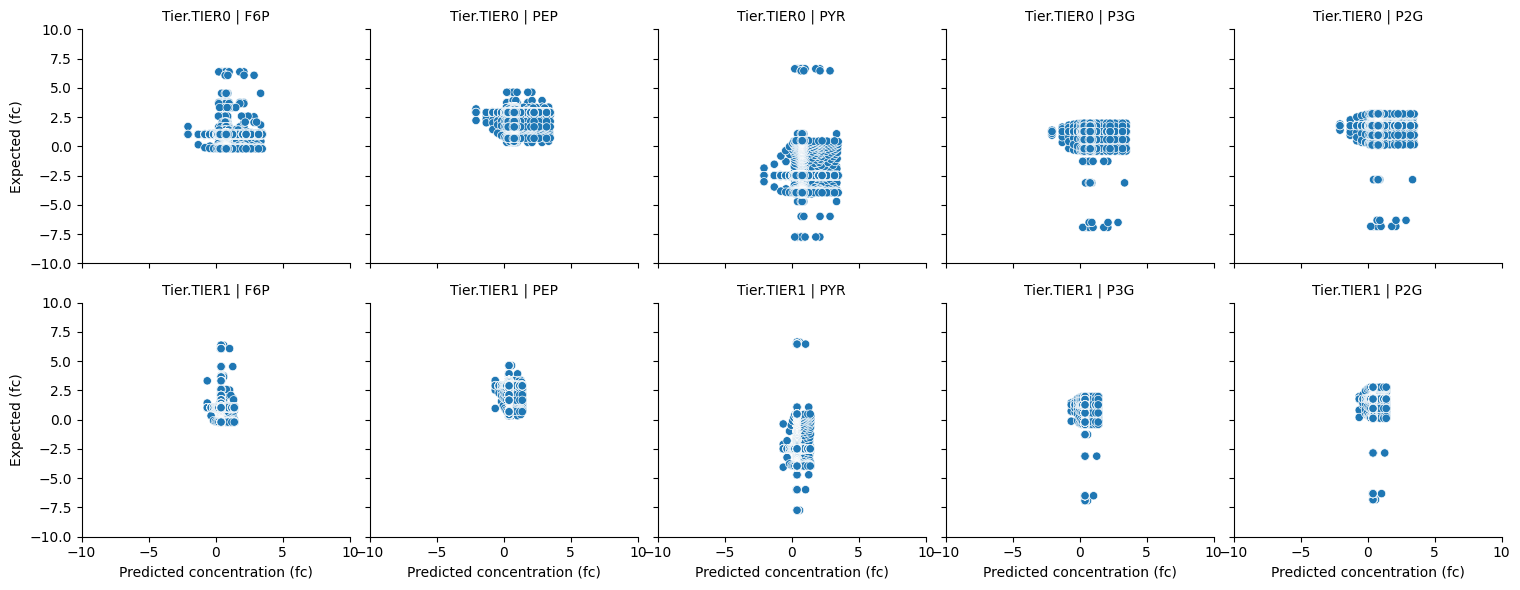

In [11]:
_df = full_df.copy()
_df = _df[_df['strategy'] == Strategy.ALL]

g = sns.FacetGrid(
    data=_df,
    row='tier',
    col='metabolite'
)

g.map_dataframe(
    sns.scatterplot,
    x='predictions',
    y='metabolite_concentration', 
    hue='strategy',
)
g.set_axis_labels("Predicted concentration (fc)", "Expected (fc)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(
    xlim=[-10, 10],
    ylim=[-10, 10]
)

(36256, 7)


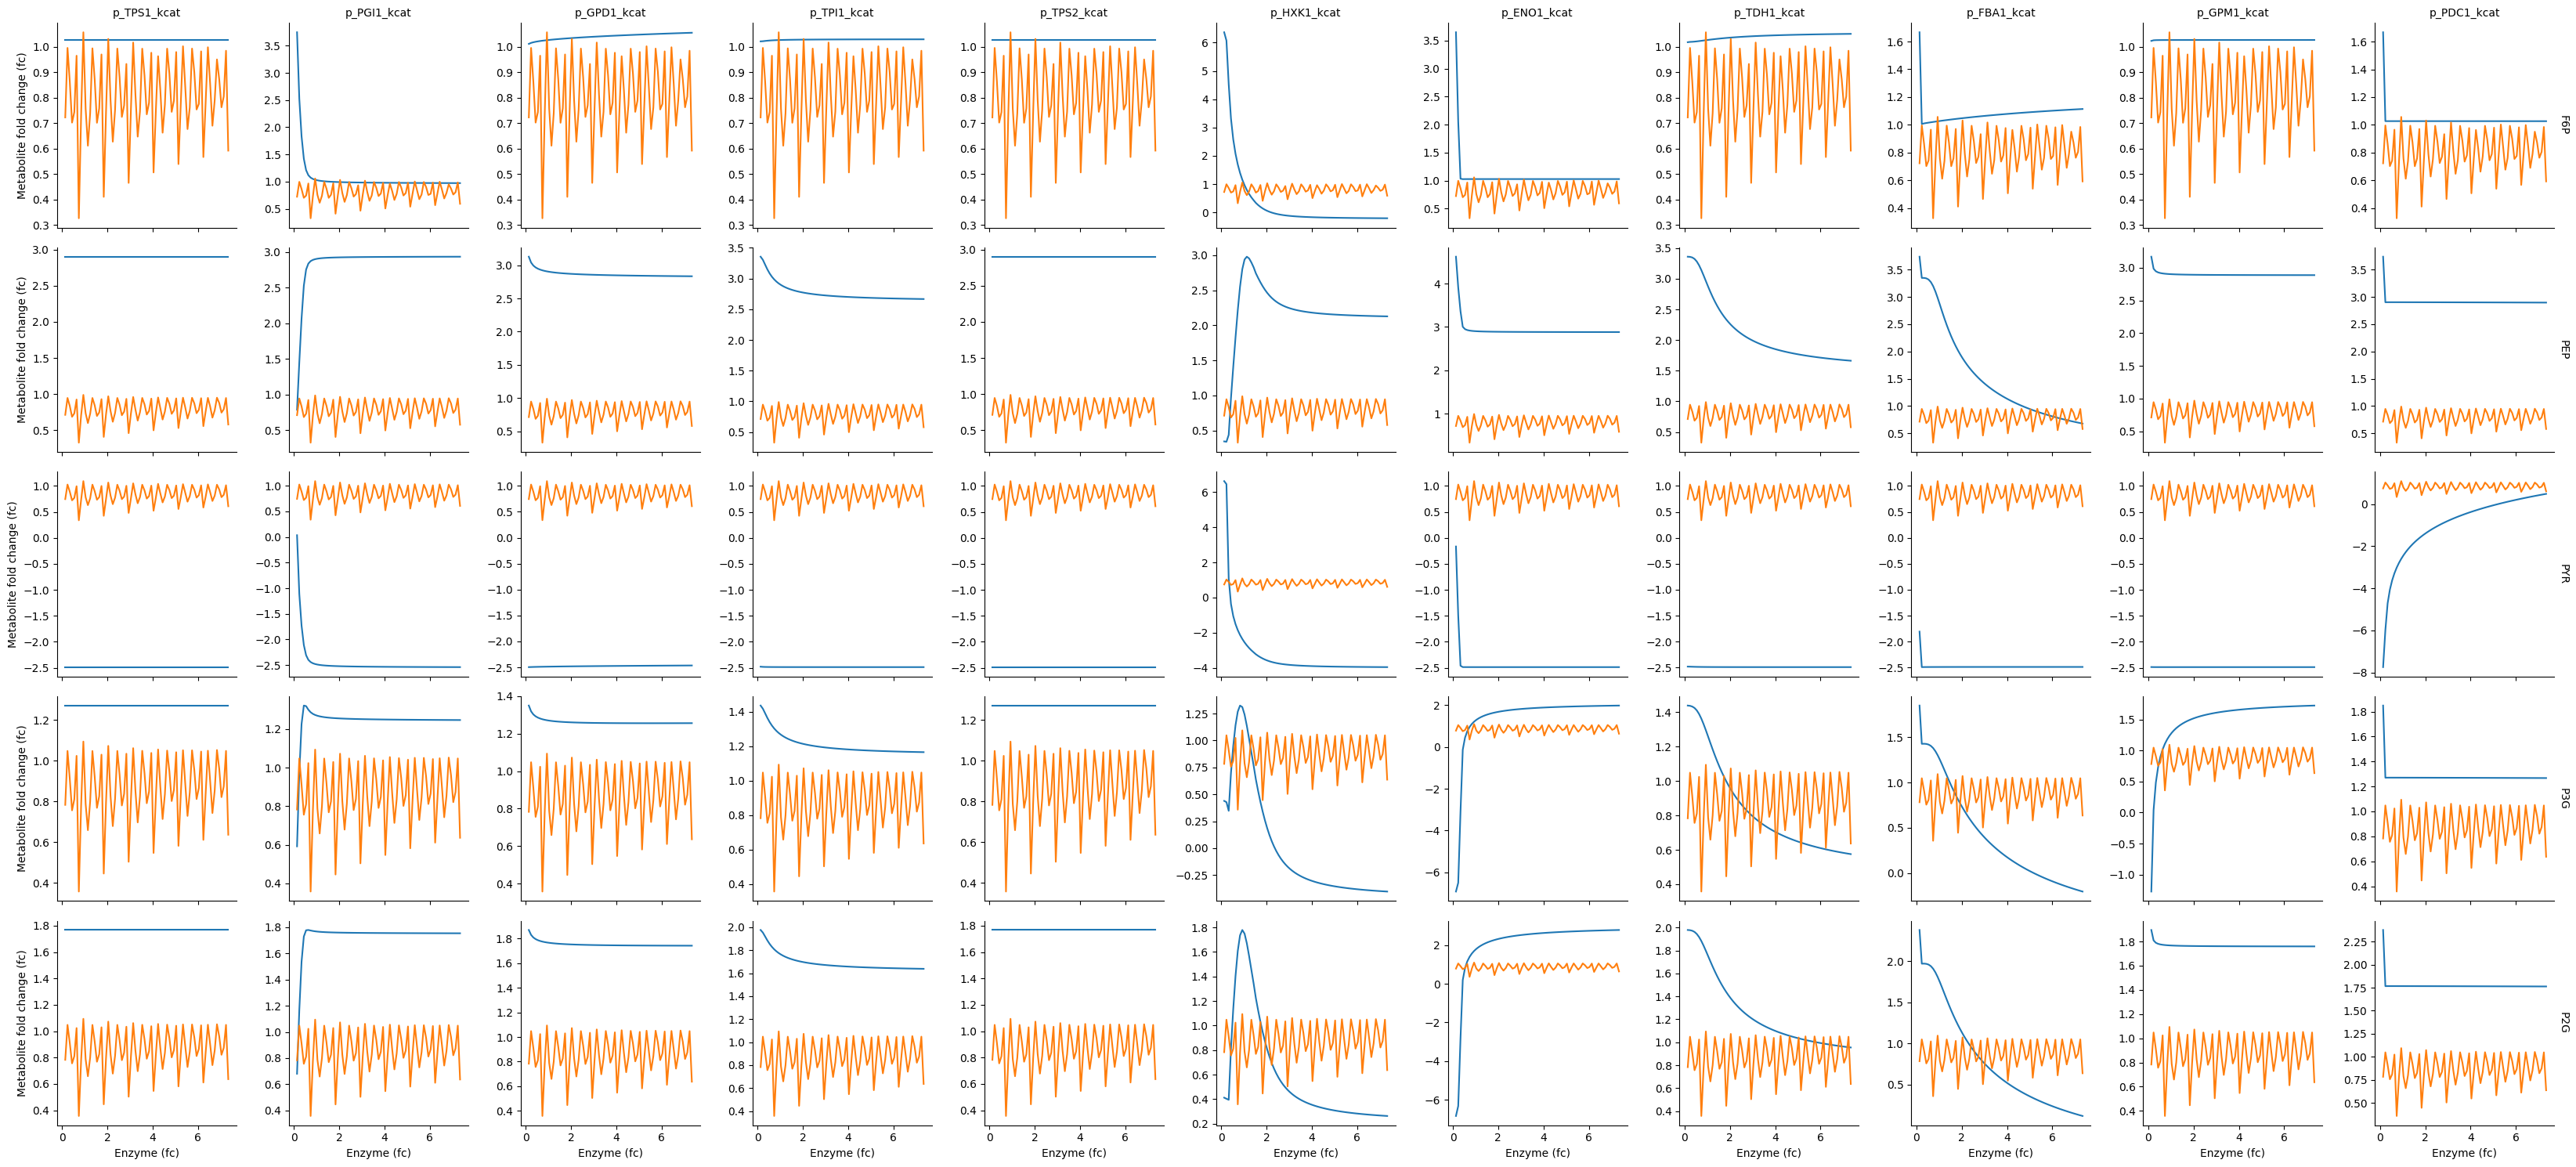

In [12]:
# _df = full_df.copy()

_df = full_df.copy()[full_df.columns.difference(['Unnamed: 0', 'sample_id', 'error', 'metabolite_id', 'orf'])]
_df = _df.melt(['tier', 'metabolite', 'strategy', 'catalyzation_id', 'fc'], value_vars=['metabolite_concentration', 'predictions']).drop_duplicates()
_df = _df[(_df['strategy'] == Strategy.ONE_VS_ALL) & (_df['tier'] == Tier.TIER0)]
print(_df.shape)

g = sns.FacetGrid(
    data=_df,
    row='metabolite',
    col='catalyzation_id',
    # col_wrap=12,
    sharey=False,
    margin_titles=True,
)
g.map_dataframe(
    sns.lineplot, 
    x="fc", y="value", hue="variable",
    errorbar=None,
)
g.set_axis_labels("Enzyme (fc)", "Metabolite fold change (fc)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
save_fig(path=f'./images/{MODE}/performance/', name="kinetic_model_vs_data_driven_single_mutation")

# Multi mutation enzyme

In [13]:
df_multi = pd.read_json('./data/validation/multi_mutation.json')
df_multi

,sample_id,enzyme_id,metabolite_id,enzyme_concentration,metabolite_concentration
0,0,p_TPS1_kcat,F6P,7.245061,-0.922484
1,0,p_PGI1_kcat,F6P,3.723038,-0.922484
2,0,p_GPD1_kcat,F6P,7.067812,-0.922484
3,0,p_TPI1_kcat,F6P,1.412729,-0.922484
4,0,p_TPS2_kcat,F6P,3.009983,-0.922484
...,...,...,...,...,...
5220,99,p_ENO1_kcat,P2G,1.420647,-0.404050
5221,99,p_TDH1_kcat,P2G,0.545890,-0.404050
5222,99,p_FBA1_kcat,P2G,0.935241,-0.404050
5223,99,p_GPM1_kcat,P2G,1.952357,-0.404050


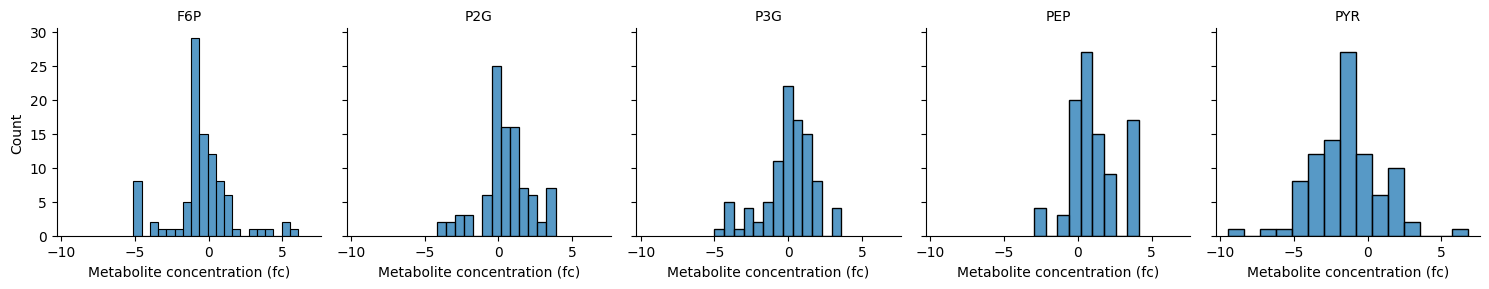

In [14]:
_df = df_multi.pivot_table(values=['metabolite_concentration'], index=['sample_id'], columns=['metabolite_id']).stack().reset_index()

g = sns.FacetGrid(
    data=_df,
    col='metabolite_id'
)

g.map_dataframe(
    sns.histplot,
    x='metabolite_concentration', 
)
g.set_axis_labels("Metabolite concentration (fc)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

In [15]:
SAMPLE_IDS = df_multi['sample_id'].unique().tolist()

def parse_kinetic_model_id_to_orf(kinetic_model_ids: List[str]):
    mapping = pd.read_csv("./data/misc/orf_to_catalyzation_id_mapping.csv")
    return [mapping[mapping["catalyzation_ids"] == kinetic_model_id]["orf"].values[0] for kinetic_model_id in kinetic_model_ids]

def embed_mutation(enzyme_concentration, target_enzyme_id):
    embedded_fc = pd.DataFrame(
        np.zeros(
            shape=(enzyme_concentration.shape[0], len(tf.x.columns))
        ),
        columns=tf.x.columns        
    )
    embedded_fc[target_enzyme_id] = np.log(enzyme_concentration.values)
    return embedded_fc

def predict(embedded_fc: pd.DataFrame, tier: Tier, strategy: Strategy, metabolite: str = "all"):
    metabolite = metabolite.lower()
    if strategy == Strategy.ALL:
        metabolite = 'all'

    if metabolite == 'p3g' or metabolite == 'p2g':
        metabolite = '3pg;2pg'

    with open(f'./model/{tier}/{strategy}_{metabolite}.pickle', 'rb') as handle:
        model = pickle.load(handle)
    
    return pd.DataFrame(data={'predictions': model.predict(embedded_fc)}).assign(sample_id=SAMPLE_IDS)

def runner(embedded_fc):
    tiers = [Tier.TIER0, Tier.TIER1]
    strategies = [Strategy.ALL, Strategy.ONE_VS_ALL, Strategy.METABOLITE_CENTRIC]
    metabolites = ['F6P', 'P2G', 'P3G', 'PEP', 'PYR']

    dfs = []
    for tier, strategy, metabolite in itertools.product(tiers, strategies, metabolites):
        dfs.append(predict(embedded_fc, tier, strategy, metabolite).assign(tier=tier, strategy=strategy, metabolite=metabolite))

    return pd.concat(dfs, ignore_index=True)

_df = df_multi.pivot_table(values=['enzyme_concentration'], index=['sample_id'], columns=['enzyme_id'])
_target_enzyme_id = parse_kinetic_model_id_to_orf(_df.columns.get_level_values('enzyme_id').to_list())
_embedded_fc = embed_mutation(_df, _target_enzyme_id)
# _predictions = predict(_embedded_fc, tier=Tier.TIER0, strategy=Strategy.ALL)
# print(_predictions.shape)
results = runner(_embedded_fc)

In [16]:
_df = df_multi.pivot_table(values=['metabolite_concentration'], index=['sample_id'], columns=['metabolite_id']).stack()
_df = _df.merge(results, left_index=True, right_on=['sample_id', 'metabolite'])
full_df = _df[_df['metabolite_concentration'].notna()]
full_df['error'] = full_df['metabolite_concentration'] - full_df['predictions']
full_df

,metabolite_concentration,predictions,sample_id,tier,strategy,metabolite,error
0,-0.922484,3.015247,0,Tier.TIER0,Strategy.ALL,F6P,-3.937731
475,-0.922484,2.058593,0,Tier.TIER0,Strategy.ONE_VS_ALL,F6P,-2.981077
950,-0.922484,1.271457,0,Tier.TIER0,Strategy.METABOLITE_CENTRIC,F6P,-2.193941
1425,-0.922484,0.613474,0,Tier.TIER1,Strategy.ALL,F6P,-1.535958
1900,-0.922484,0.577418,0,Tier.TIER1,Strategy.ONE_VS_ALL,F6P,-1.499901
...,...,...,...,...,...,...,...
949,-1.413516,1.429298,99,Tier.TIER0,Strategy.ONE_VS_ALL,PYR,-2.842814
1424,-1.413516,0.809517,99,Tier.TIER0,Strategy.METABOLITE_CENTRIC,PYR,-2.223033
1899,-1.413516,0.220586,99,Tier.TIER1,Strategy.ALL,PYR,-1.634102
2374,-1.413516,0.190984,99,Tier.TIER1,Strategy.ONE_VS_ALL,PYR,-1.604500


In [20]:
def _mean_squared_error(errors):
    return np.mean(np.abs(errors))

_df = full_df.copy()
_df = _df[(_df['metabolite_concentration'] >= -2.0) & (_df['metabolite_concentration'] < 2.0)].


_df.pivot_table(
    values='error',
    index=['tier', 'strategy'],
    columns='metabolite',
    aggfunc=_mean_squared_error
)

metabolite                                   F6P       P2G       P3G  \
tier       strategy                                                    
Tier.TIER0 Strategy.ALL                 3.826374  3.224039  3.242967   
           Strategy.METABOLITE_CENTRIC  1.495827  0.878119  0.981204   
           Strategy.ONE_VS_ALL          2.748189  2.420327  2.483530   
Tier.TIER1 Strategy.ALL                 1.392453  0.874246  0.996995   
           Strategy.METABOLITE_CENTRIC  0.970073  0.593213  0.679514   
           Strategy.ONE_VS_ALL          1.400110  0.896521  1.020008   

metabolite                                   PEP       PYR  
tier       strategy                                         
Tier.TIER0 Strategy.ALL                 3.106071  4.051976  
           Strategy.METABOLITE_CENTRIC  0.668988  1.925322  
           Strategy.ONE_VS_ALL          1.917233  3.147918  
Tier.TIER1 Strategy.ALL                 0.775019  1.820260  
           Strategy.METABOLITE_CENTRIC  2.238693  3.514613  
           Strategy.ONE_VS_ALL          0.643280  1.698588

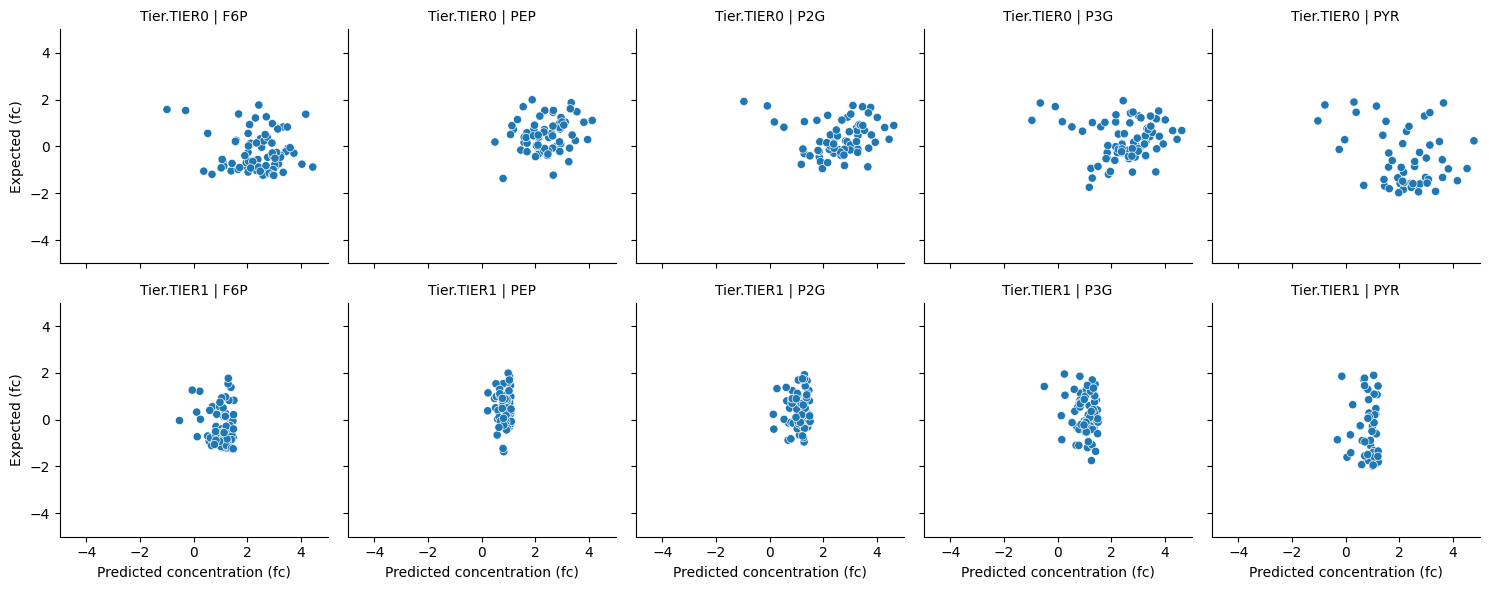

In [21]:
_df = full_df.copy()
_df = _df[(_df['strategy'] == Strategy.ONE_VS_ALL)]
_df = _df[(_df['metabolite_concentration'] >= -2.0) & (_df['metabolite_concentration'] < 2.0)]

g = sns.FacetGrid(
    data=_df,
    row='tier',
    col='metabolite'
)

g.map_dataframe(
    sns.scatterplot,
    x='predictions',
    y='metabolite_concentration', 
    hue='strategy',
)
g.set_axis_labels("Predicted concentration (fc)", "Expected (fc)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(
    xlim=[-5, 5],
    ylim=[-5, 5]
)

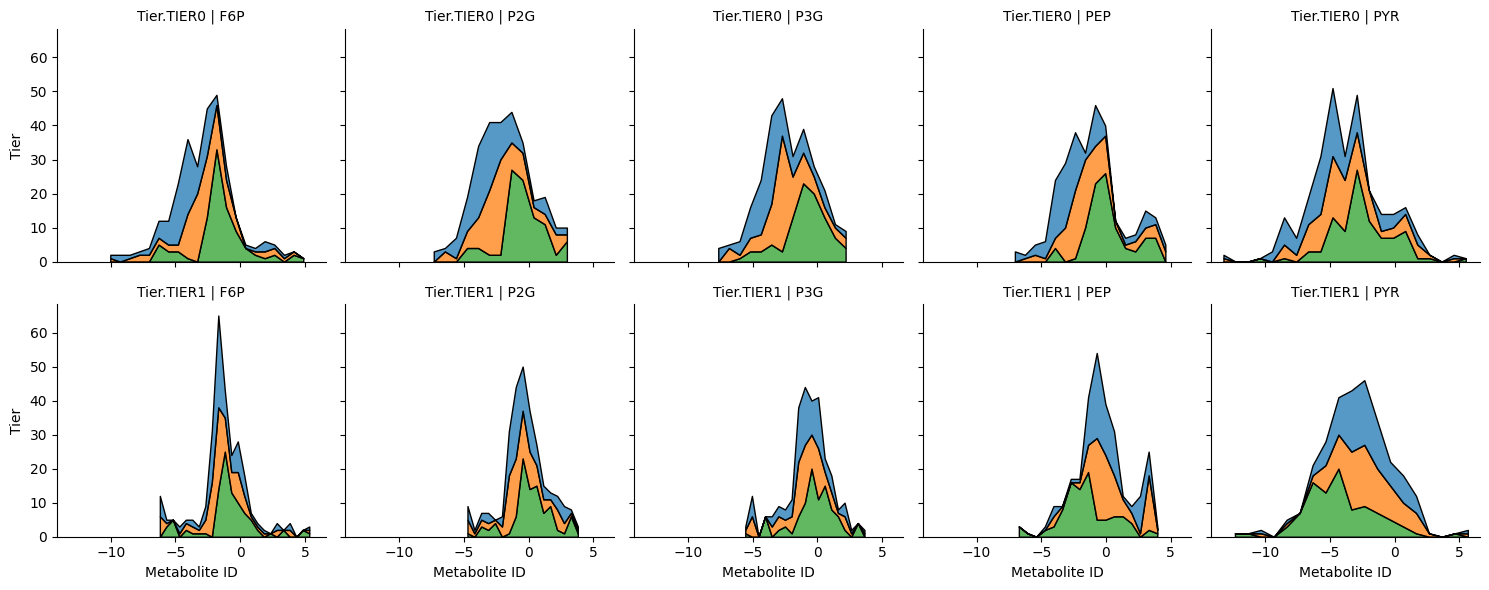

In [22]:
g = sns.FacetGrid(
    data=full_df,
    row='tier',
    col='metabolite'
)

g.map_dataframe(
    sns.histplot,
    x='error', 
    hue='strategy',
    # cumulative=True,
    multiple='stack',
    element='poly'
)
g.set_axis_labels("Metabolite ID", "Tier")
g.set_titles(col_template="{col_name}", row_template="{row_name}")


# sns.histplot(data=full_df, x='error', hue='strategy')

In [23]:
df_multi.pivot_table(values=['metabolite_concentration'], index=['repeat_id', 'sample_id'], columns=['metabolite_id']).stack().reset_index()

KeyError: 'repeat_id'